1. IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2. TIỀN XỬ LÝ DỮ LIỆU:

In [3]:
# Load dữ liệu
def load_dataset_from_dir(data_dir, img_size=(224,224)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)                   
                img = img.astype(np.float16) / 255.0              
                X.append(img)
                y.append(cls)                                     

    X = np.array(X)                                         
    y = np.array(y)

    return X, y, label_map


# Đọc dữ liệu
dataset_path_train = '/kaggle/input/custom-ml-data/hand_written_digit/train'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(224,224))
print(f"Tổng số ảnh: {len(X_train)}")

Tổng số ảnh: 4250


In [4]:
# Encode nhãn và chia dữ liệu train/test
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
num_classes = len(le.classes_)

print(y_train_num)

[0 0 0 ... 9 9 9]


In [5]:
# Chia tập train-valid tỉ lệ 8-2
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

print(f"Số ảnh TRAIN: {len(X_train_sub)}")
print(f"Số ảnh VALIDATION: {len(X_val)}")

Số ảnh TRAIN: 3400
Số ảnh VALIDATION: 850


In [5]:
# One-hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)

print(Y_train)
print(Y_val)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


3. XÂY DỰNG MÔ HÌNH

In [6]:
# Load pre-train model VGG
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp của VGG
for layer in vgg16.layers:
    layer.trainable = False

# Thêm các lớp mới cho bài toán phân loại
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 
output = Dense(num_classes, activation='softmax')(x)

I0000 00:00:1750419935.756696      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750419935.757421      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Tạo mô hình mới từ VGG16 + các lớp phân loại mới
model = Model(inputs=vgg16.input, outputs=output)

model.summary()

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. HUẤN LUYỆN MÔ HÌNH CNN

In [8]:
# training
H = model.fit(
    X_train_sub, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/500


I0000 00:00:1750419945.529701      64 service.cc:148] XLA service 0x7d35400075d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750419945.530435      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750419945.530466      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750419945.897496      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-20 11:45:56.639890: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=3,k3=0} for conv (f32[224,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[224,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earlies

12/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1437 - loss: 4.1650

2025-06-20 11:47:01.552148: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[97,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[97,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-20 11:47:01.599728: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.047776082s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[97,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[97,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

13/13 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.1493 - loss: 4.0394 - val_accuracy: 0.3027 - val_loss: 1.9217
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3044 - loss: 1.9255 - val_accuracy: 0.5796 - val_loss: 1.5782
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4342 - loss: 1.6460 - val_accuracy: 0.6255 - val_loss: 1.3582
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4889 - loss: 1.4896 - val_accuracy: 0.7260 - val_loss: 1.1792
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5441 - loss: 1.3555 - val_accuracy: 0.7604 - val_loss: 1.0887
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5929 - loss: 1.2129 - val_accuracy: 0.7948 - val_loss: 0.9797
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6433 - loss: 1.1439 - val_accuracy: 0.8135 - val_loss: 0.8764
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6730 - loss: 1.0506 - val_accuracy: 0.8235 - val_loss: 0.

In [9]:
# save model
os.makedirs("/kaggle/working", exist_ok=True)
model.save("/kaggle/working/vgg16_finetuned_model.keras")

5. VISUALIZATION

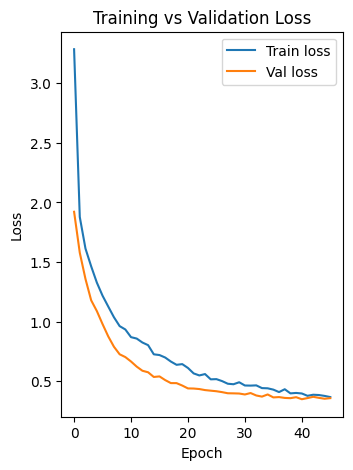

<function matplotlib.pyplot.show(close=None, block=None)>

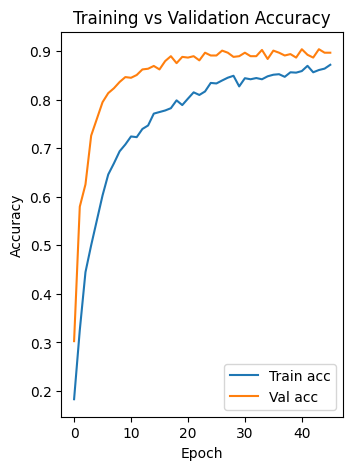

In [10]:
# 12. Vẽ đồ thị loss và accuracy của training & validation
# Loss
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Train loss')
plt.plot(H.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Train acc')
plt.plot(H.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show


6. PREDICT TRÊN TẬP TEST

In [11]:
import os
import cv2
import numpy as np

# Hàm dự đoán và lưu kết quả
def predict_and_save_results(model, data_dir, img_size=(224,224)):
    X, filenames = [], []
    
    # Kiểm tra lại img_size có đúng định dạng không
    if not isinstance(img_size, tuple) or len(img_size) != 2:
        raise ValueError(f"img_size phải là một tuple có 2 phần tử. Hiện tại là {img_size}")
    
    # Duyệt qua tất cả các file trong thư mục dữ liệu
    for fname in os.listdir(data_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Lọc các ảnh
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi sang RGB
            
            # Resize hình ảnh về kích thước 224x224
            img = cv2.resize(img, img_size)  # Resize ảnh
            img = img.astype(np.float16) / 255.0  # Chuẩn hóa ảnh
            X.append(img)
            filenames.append(fname)
    
    # Chuyển X thành mảng numpy
    X = np.array(X)
    
    # Dự đoán nhãn
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)  # Lấy nhãn có xác suất cao nhất

    # Lưu kết quả vào file CSV với định dạng tên file và nhãn
    result_file = '/kaggle/working/predictions.csv'
    with open(result_file, 'w') as f:
        for fname, predicted_class in zip(filenames, predicted_classes):
            # Đảm bảo giữ nguyên tên file đầy đủ (bao gồm phần mở rộng)
            f.write(f"{fname},{predicted_class}\n")
    
    print(f"Results saved to {result_file}")

# Dự đoán cho bộ test
dataset_path_test = '/kaggle/input/hand-written'
predict_and_save_results(model, dataset_path_test)

305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 277ms/step
Results saved to /kaggle/working/predictions.csv
